In [1]:
# Standard imports
import numpy as np
import torchvision
import torchvision.transforms as T
from mynet import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
img_size = 28
ds = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11981832.09it/s]


Extracting ./files/MNIST\raw\train-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1075051.20it/s]


Extracting ./files/MNIST\raw\train-labels-idx1-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5821707.33it/s]


Extracting ./files/MNIST\raw\t10k-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2266840.64it/s]

Extracting ./files/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/MNIST\raw



In [4]:
def draw(x):
    '''Displays a flattened MNIST digit'''
    with torch.no_grad():
        plt.imshow(x.cpu().numpy().reshape((img_size,img_size)), cmap='gray');
        plt.axis('off');

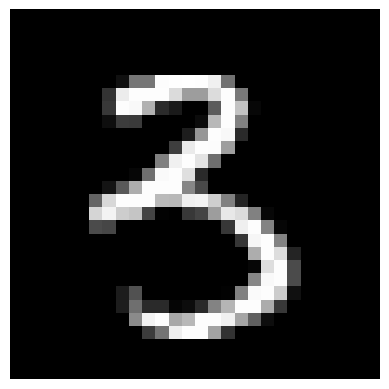

In [5]:
# Check function draw
x,t = ds.__getitem__(5000)
draw(x)

100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


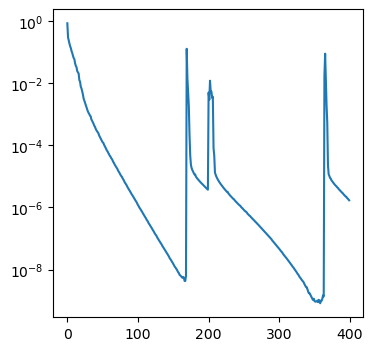

In [8]:
# train the network
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)
net.learn(dl, optimizer=torch.optim.Adam(net.parameters(), lr=0.001), epochs=200)

In [9]:
# Save the network
torch.save(net.cpu(), 'mnist_trained2.pt')

In [10]:
# Use the trained network
net = torch.load('mnist_trained2.pt').to(device)

Accuracy = 100.00%


Text(0.5, 1.0, 'Predicted: 7, True: 7')

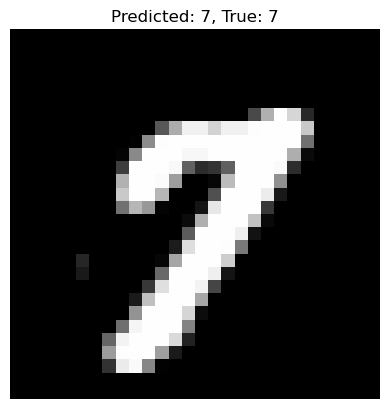

In [11]:
# test its accuracy.
# The network should have a test accuracy over 97%.

def accuracy(net, dl):
    total_correct = 0.
    for x,t in dl:
        y = net(x.to(device))
        blah = torch.argmax(y.cpu(), dim=1)
        total_correct += torch.sum(blah==t).cpu().item()
    return total_correct/len(dl.dataset)

dl = torch.utils.data.DataLoader(ds, batch_size=256)
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

# Classify a random digit
idx = np.random.randint(len(ds))
x, t = ds.__getitem__(idx)
x = x.to(device)
y = net(x)
draw(x)
plt.title(f'Predicted: {torch.argmax(y)}, True: {t}')

# Untargetted Adversarial Attack

In [12]:
# Create a batch consisting of one correctly-classified digit
# from each class.
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)
x = [None] * 10  # to store the image data for digits 0 through 9
t = [None] * 10  # to store the corresponding labels for digits 0 through 9
found_digits = [False] * 10
    
for a, b in dl:
    digit = b.item()
    if not found_digits[digit]:
        net.eval()
        with torch.no_grad():
            pred = net(a.to(device)).max(1)[1]
        if pred.item() == digit:
            x[digit] = a
            t[digit] = b
            found_digits[digit] = True
        if all(found_digits):
            break

x = torch.cat(x, dim=0).to(device)
t = torch.cat(t, dim=0).to(device)

In [13]:
x_adv = fgsm(net, x, t, 0.07)

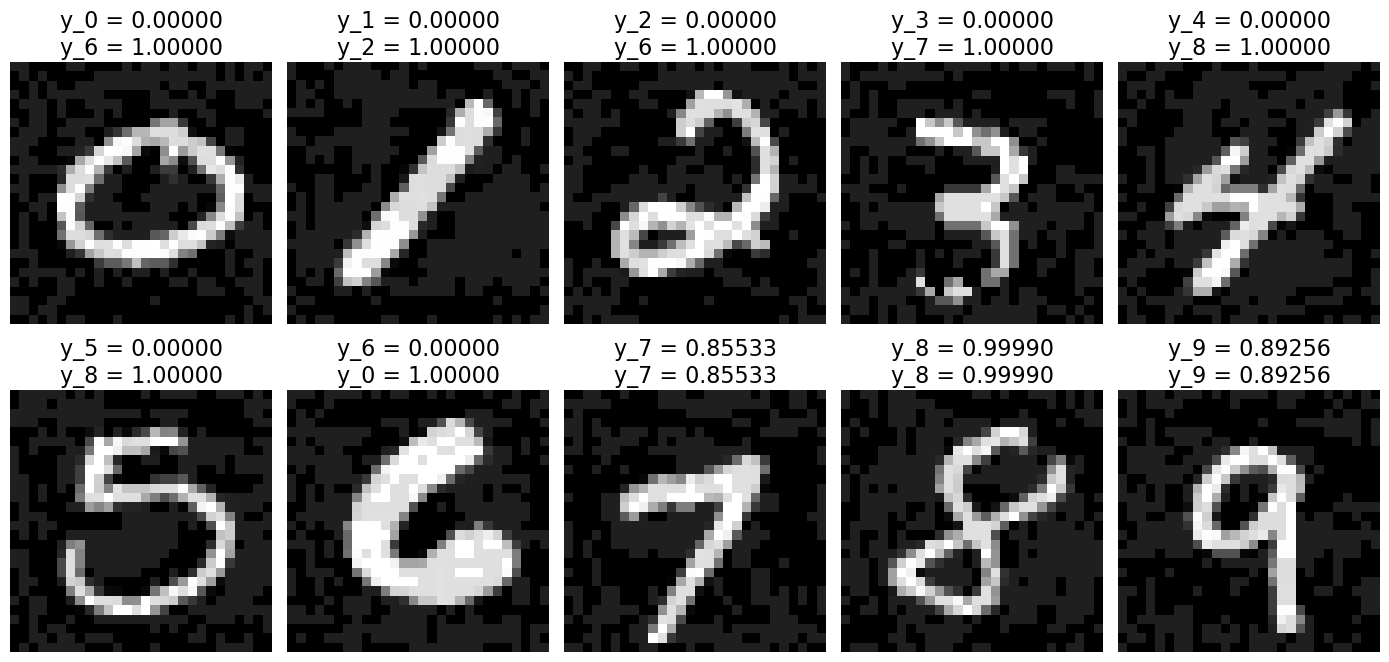

In [14]:
# Display all 10 digits, including the true class/probability,
# and the predicted class/probability.
net.eval()  
with torch.no_grad():
    outputs = net(x_adv)
    probs, preds = torch.softmax(outputs, dim=1).max(1)
    true_probs = torch.softmax(outputs, dim=1).gather(1, t.view(-1, 1)).squeeze()

plt.figure(figsize=(14,7))
for n, (xx, prob, pred, true_prob, true_label) in enumerate(zip(x_adv, probs, preds, true_probs, t)):
    plt.subplot(2,5,n+1)
    draw(xx)
    title_str = f'y_{true_label.item()} = {true_prob:.5f}\ny_{pred.item()} = {prob:.5f}'
    plt.title(title_str, fontsize=16)
plt.tight_layout()
plt.show()

# Targetted Adversarial Attack

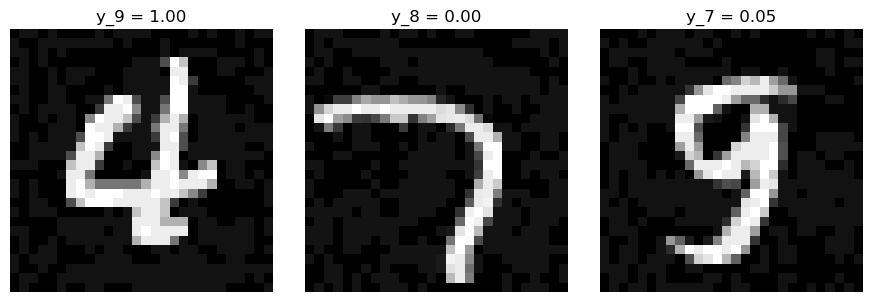

In [15]:
# Targetted Adversarial Attack
# Choose 3 inputs (different classes)
specified_classes = [4, 7, 9]
selected_images = {label: None for label in specified_classes}
selected_labels = {label: None for label in specified_classes}

for img, label in dl:
    label_item = label.item()
    if label_item in specified_classes and selected_images[label_item] is None:
        img, label = img.to(device), label.to(device)
        output = net(img)
        pred = output.argmax(dim=1, keepdim=True)
        if pred.item() == label_item:
            selected_images[label_item] = img
            selected_labels[label_item] = label
        if all(image is not None for image in selected_images.values()):
            break

x_479 = torch.cat([selected_images[label] for label in specified_classes], dim=0)
t_selected = torch.cat([selected_labels[label] for label in specified_classes], dim=0)

epsilon = 0.04
target_classes_479 = torch.tensor([9, 8, 7], device=device)
x_adv_479 = fgsm(net, x_479, target_classes_479, eps=epsilon, targ=True)

net.eval()
with torch.no_grad():
    outputs = net(x_adv_479)
    probs = torch.softmax(outputs, dim=1)
    target_probs = probs.gather(1, target_classes_479.unsqueeze(1)).squeeze()

plt.figure(figsize=(9, 3))
for i in range(len(x_adv_479)):
    plt.subplot(1, len(x_adv_479), i+1)
    img = x_adv_479[i].squeeze().detach().cpu().numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f'y_{target_classes_479[i].item()} = {target_probs[i].item():.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()